In [2]:
"""
Author: Valentina Matos (Johns Hopkins - Wirtz/Kiemen Lab)
Date: June 22, 2024
"""
import os
import numpy as np
from base import *

In [3]:
from CODAGUI_fend import MainWindow
import sys
from PySide6 import QtWidgets

# Execute the GUI
app = QtWidgets.QApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)
    
# Load and apply the dark theme stylesheet
with open('dark_theme.qss', 'r') as file:
    app.setStyleSheet(file.read())

window = MainWindow()
window.show()
app.exec()


Form filled with: 
Training path: //10.99.68.52/Kiemendata/Valentina Matos/tissues for methods paper/human skin/test model
Testing path: //10.99.68.52/Kiemendata/Valentina Matos/tissues for methods paper/human skin/test model/testing annotations
Model name: 09_04_2024
Resolution: 5x
Loaded XML file: //10.99.68.52/Kiemendata/Valentina Matos/tissues for methods paper/human skin/test model\OTS-21-11041 - 2021-11-15 12.13.09.xml
      Layer Name           Color Whitespace Settings
0       follicle     (0, 255, 0)                None
1    sweat gland   (128, 0, 128)                None
2      oil gland   (0, 128, 255)                None
3      epidermis   (255, 255, 0)                None
4         nerves    (128, 64, 0)                None
5  blood vessels     (255, 0, 0)                None
6            fat   (0, 255, 255)                None
7       collagen  (255, 128, 64)                None
8     whitespace     (0, 0, 255)                None


0

In [4]:
#_______________Variable parametrization from GUI_______________

#Paths
pth = window.ui.trianing_LE.text()
pthtest = window.ui.testing_LE.text()
model_name = window.ui.model_name.text()
resolution = window.ui.resolution_CB.currentText()
pthim = os.path.join(pth, f'{resolution}')
pthDL = os.path.join(pth, model_name)

#Tif resolution
resolution_to_umpix = {"10x": 1, "5x": 2, "16x": 4}
umpix = resolution_to_umpix.get(resolution, 2)  # Default to 2 if resolution not found

# Get the dataframe with annotation information
combined_df = window.combined_df
classNames = combined_df['Combined names'].tolist()
colormap = combined_df['Combined colors'].tolist()

#Training tile size
tile_size = window.tile_size
#Number of training tiles
ntrain = window.ntrain
nvalidate = window.nval
#Number of validations tiles
nval = window.nval
#Number of TA images to evaluate (coming sooon)
# TA = window.TA

#Create WS
df = window.df
layers_to_delete = df.index[df['Delete layer']].tolist()
layers_to_delete = [i+1 for i in layers_to_delete] #get row index starting from 1
nesting_list = df['Nesting'].tolist()
nesting_list.reverse()
WS = [df['Whitespace Settings'].tolist(),
      [window.add_ws_to, window.add_nonws_to],
      df['Combined layers'].tolist(),
      nesting_list,
      layers_to_delete
      ]


numclass = max(WS[2])
nblack = numclass + 1;nwhite = WS[1][0]

colormap = np.array(colormap)

#Final Parameters
print('Classnames: ', classNames)
print('Colormap: ', colormap)
print(WS)

Classnames:  ['islets', 'normal duct', 'blood vessel', 'fat', 'acini', 'ecm', 'whitespace', 'panin', 'noise', 'nerve', 'immune', 'HG panin', 'PDAC', 'weird']
Colormap:  [[  0 255   0]
 [255 255   0]
 [255   0   0]
 [  0 255 255]
 [255   0 255]
 [255 128  64]
 [  0   0 255]
 [255   0 128]
 [ 64 128 128]
 [128   0 255]
 [  0 128 255]
 [128   0 128]
 [ 64   0  64]
 [255   0   0]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 4], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1], []]


Saving model metadata and classification colormap...
Creating Net metadata file...
Plotting cmap took 0.0 minutes and 0.02551102638244629 seconds
Saving metadata took 0.0 minutes and 0.06803035736083984 seconds


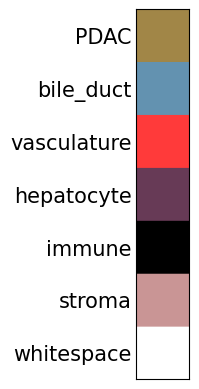

In [19]:
# 1 save model metadata
save_model_metadata(pthDL, pthim, WS, model_name, umpix, colormap, tile_size, classNames, ntrain, nvalidate)

In [22]:
# 2 load and format annotations from each annotated image
# WSI2tif(pth, resolution, umpix) # Create tif images from /.ndpi / .svs
[ctlist0, numann0] = load_annotation_data(pthDL, pth, pthim)

 
Importing annotation data...
Image 1 of 6: Liv-17_0001
Checking parameters took 0.0 minutes and 0.07610654830932617 seconds
 annotation data previously loaded
Image 2 of 6: Liv-17_0041
Checking parameters took 0.0 minutes and 0.061867475509643555 seconds
 annotation data previously loaded
Image 3 of 6: Liv-17_0081
Checking parameters took 0.0 minutes and 0.07853960990905762 seconds
 annotation data previously loaded
Image 4 of 6: Liv-17_0121
Checking parameters took 0.0 minutes and 0.025510072708129883 seconds
 annotation data previously loaded
Image 5 of 6: Liv-17_0161
Checking parameters took 0.0 minutes and 0.025005102157592773 seconds
 1. of 4. Importing annotation data from xml file
Loading annotation took 0.0 minutes and 0.21580862998962402 seconds
 Creating file...
Import xml took 0.0 minutes and 0.23991918563842773 seconds
  Existing TA loaded
Calculating tissue mask took 0.0 minutes and 29.92670488357544 seconds
 2. of 4. Interpolating annotated regions and saving mask image

MemoryError: Unable to allocate 6.29 GiB for an array with shape (844248776,) and data type int64

In [9]:
# 3 Make training & validation tiles for model training
create_training_tiles(pthDL, numann0, ctlist0)

 
Importing annotation data...
Image 1 of 6: Liv-17_0001
Reload annotation data with updated WS.
Checking parameters took 0.0 minutes and 0.07873320579528809 seconds
 1. of 4. Importing annotation data from xml file
Loading annotation took 0.0 minutes and 0.26817822456359863 seconds
 Creating file...
Import xml took 0.0 minutes and 0.2979273796081543 seconds
  Existing TA loaded
Calculating tissue mask took 0.0 minutes and 24.67608141899109 seconds
 2. of 4. Interpolating annotated regions and saving mask image

Calculating total number of pixels in the training dataset...
 There are 544424200.0 pixels of PDAC, 41% of the most common class.
 There are 32237300.0 pixels of bile duct, 2% of the most common class.
 There are 92535400.0 pixels of vasculature, 7% of the most common class.
 There are 1312608300.0 pixels of hepatocyte. This is the most common class.
 There are 32903400.0 pixels of immune, 2% of the most common class.
 There are 655049200.0 pixels of stroma, 49% of the most co

TensorFlow is using the following GPU: LogicalDevice(name='/device:GPU:0', device_type='GPU')
Starting model training...
Epoch 1/8
375/375 [==============================] - 6294s 10s/step - loss: 0.3022 - accuracy: 0.8924 - val_loss: 0.2276 - val_accuracy: 0.9103
Epoch 2/8
375/375 [==============================] - 3074s 8s/step - loss: 0.1711 - accuracy: 0.9362 - val_loss: 0.1443 - val_accuracy: 0.9461
Epoch 3/8
375/375 [==============================] - 3055s 8s/step - loss: 0.1433 - accuracy: 0.9463 - val_loss: 0.1481 - val_accuracy: 0.9453
Epoch 4/8
375/375 [==============================] - 3043s 8s/step - loss: 0.1151 - accuracy: 0.9567 - val_loss: 0.1558 - val_accuracy: 0.9450
Epoch 5/8
375/375 [==============================] - 3040s 8s/step - loss: 0.1049 - accuracy: 0.9604 - val_loss: 0.2313 - val_accuracy: 0.9263
Epoch 6/8
375/375 [==============================] - 3038s 8s/step - loss: 0.1015 - accuracy: 0.9620 - val_loss: 6.0075 - val_accuracy: 0.2774
Epoch 7/8
375/375 [=

INFO:tensorflow:Assets written to: ram://7a3da428-fe01-40c1-a95d-991f8750f0b2/assets


INFO:tensorflow:Assets written to: ram://7a3da428-fe01-40c1-a95d-991f8750f0b2/assets


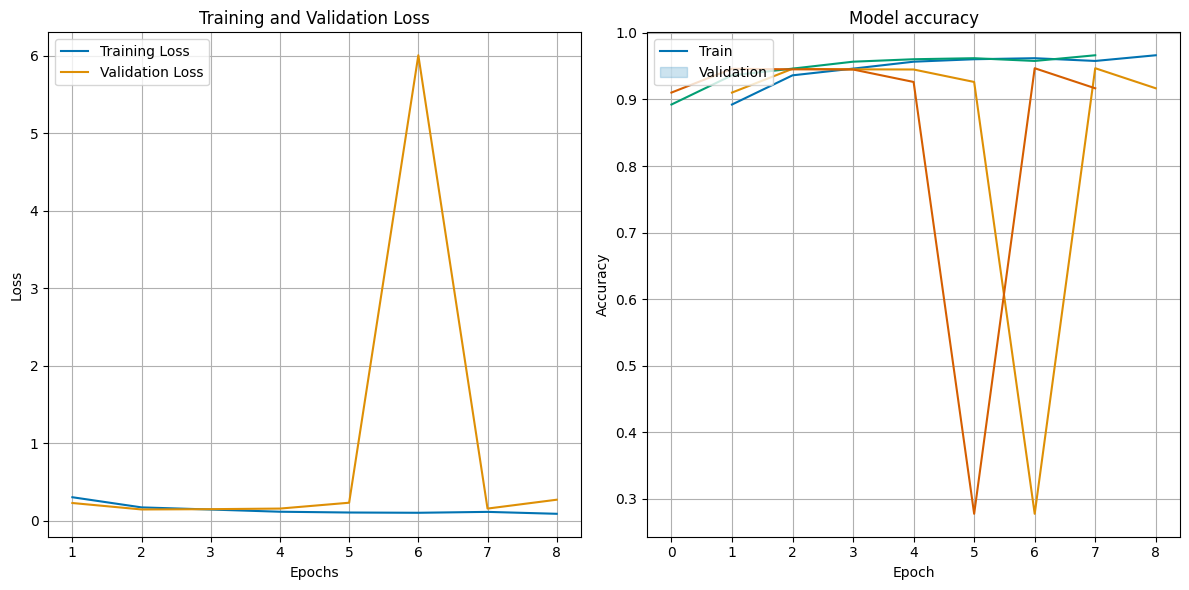

In [10]:
# 4 Train model
train_segmentation_model(pthDL)

In [11]:
# 5 Test model
pthtestim = os.path.join(pthtest, f'{resolution}')
# WSI2tif(pthtest, resolution, umpix)
test_segmentation_model(pthDL, pthtest, pthtestim)

Testing segmentation model......


FileNotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ram://ea8b218e-c7d3-4933-a7ed-a374163d6e73/variables/variables
 You may be trying to load on a different device from the computational device. Consider setting the `experimental_io_device` option in `tf.saved_model.LoadOptions` to the io_device such as '/job:localhost'.

In [ ]:
# 6 Classify images with pretrained model
classify_images(pthim,pthDL)

In [ ]:
# 6 Classify images with pretrained model
classify_images(pthim,pthDL)

In [4]:

def compare_tif_and_png(tif_path, png_path):
    # Load the TIFF image using Pillow
    with Image.open(tif_path) as tif_image:
        tif_image = np.array(tif_image)
    
    # Load the PNG image using Pillow
    with Image.open(png_path) as png_image:
        png_image = np.array(png_image)
        
        # Ensure images have the same size
        if tif_image.shape != png_image.shape:
            raise ValueError("Images must have the same dimensions")
        
        # Compare pixel by pixel
        total_pixels = tif_image.size
        matching_pixels = np.sum(tif_image == png_image)
        
        # Calculate percentage similarity
        similarity_percentage = (matching_pixels / total_pixels) * 100
        return similarity_percentage
    
png_path =  r'\\10.99.68.52\Kiemendata\Valentina Matos\tissues for methods paper\mouse lung\testfiles python\testing images\5x\TA\TVWT 2-2 2.tif'

tif_path =  r'\\10.99.68.52\Kiemendata\Valentina Matos\tissues for methods paper\mouse lung\testfiles python\testing images\5x\TA python\TVWT 2-2 2.tif'

compare_tif_and_png(tif_path, png_path)
   
   

95.78857188791272

In [6]:
from PIL import Image

# Set the pixel limit to None to effectively remove the limit
Image.MAX_IMAGE_PIXELS = None

import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim

def compare_images(img1_path, img2_path):
    # Open and convert images to grayscale
    img1 = Image.open(img1_path).convert('RGB')
    img2 = Image.open(img2_path).convert('RGB')
    
    # Convert images to numpy arrays
    img1_array = np.array(img1)
    img2_array = np.array(img2)
    
    # Convert to floating point for SSIM calculation
    img1_array = img1_array.astype(np.float64)
    img2_array = img2_array.astype(np.float64)
    
    # Calculate Mean Squared Error (MSE)
    mse = np.mean((img1_array - img2_array) ** 2)
    
    # Convert images to grayscale
    img1_gray = np.mean(img1_array, axis=2)
    img2_gray = np.mean(img2_array, axis=2)
    
    # Calculate Structural Similarity Index (SSIM)
    # Set data_range to the range of pixel values (e.g., 255 for 8-bit images)
    data_range = img1_gray.max() - img1_gray.min()
    ssim_index, _ = ssim(img1_gray, img2_gray, full=True, data_range=data_range)
    
    return mse, ssim_index

# Example usage
if __name__ == '__main__':
    img1_path = r'\\10.99.68.52\Kiemendata\Valentina Matos\tissues for methods paper\slides scanned from bispecific study\5x tif\2024-03-15 15.06.tif'
    img2_path = r'\\10.99.68.52\Kiemendata\Valentina Matos\tissues for methods paper\slides scanned from bispecific study\5x\2024-03-15 15.06.png'
    
    mse, ssim_index = compare_images(img1_path, img2_path)
    
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Structural Similarity Index (SSIM): {ssim_index}")


In [4]:

import subprocess

# Path to the designer executable
designer_path = r'C:\Users\Valentina\AppData\Local\anaconda3\envs\ANACODA_GUI\Lib\site-packages\PySide6\designer.exe'

# Open Qt Designer
subprocess.Popen([designer_path])

<Popen: returncode: None args: ['C:\\Users\\Valentina\\AppData\\Local\\anaco...>

In [21]:
from PIL import Image
import numpy as np
Image.MAX_IMAGE_PIXELS = None

pth1 = r'\\10.99.68.52\Kiemendata\Valentina Matos\tissues for methods paper\human pancreas ready to train\test model\5x\classification_03_12_2024\6520-197 HE.tif'
pth2 = r'\\10.99.68.52\Kiemendata\Valentina Matos\tissues for methods paper\human pancreas ready to train\test model\5x\classification_ANACODA_08_28_2024\6520-197 HE.tif'

#compere images

def compare_images(img1_path, img2_path):
    # load imageas as grayscale
    img1 = Image.open(img1_path).convert('L')
    img2 = Image.open(img2_path).convert('L')
    
    #convert images to numpy arrays
    img1_array = np.array(img1)
    img2_array = np.array(img2)
    
    #tissue image
    img1_array_tissue = img1_array != 5
    img2_array_tissue = img2_array != 5
    
    #calcualte pixel difference
    diff = np.sum(img1_array_tissue != img2_array_tissue)
    
    #calculate percentage similarity
    total_pixels = img1_array_tissue.size
    similarity_percentage = (1 - diff / total_pixels) * 100
    
    return similarity_percentage

similarity_percentage = compare_images(pth1, pth2)
print(f"Similarity percentage: {similarity_percentage:.2f}%")
    

Similarity percentage: 94.88%


\\10.99.68.52\Kiemendata\Valentina Matos\tissues for methods paper\mouse lung\annotations\5x\classification_04_05_2024\diff.jpg


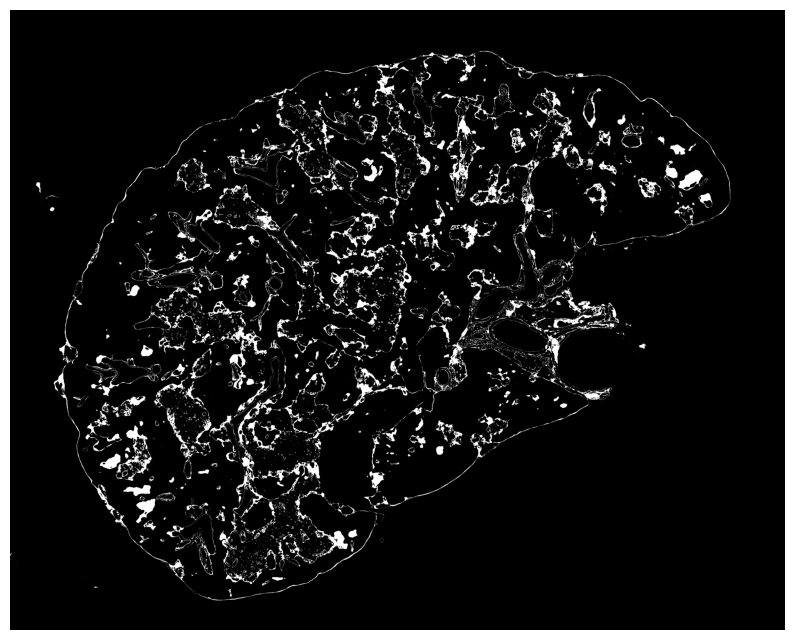

In [20]:
# plot black and white pixel difference of the images:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
pth1 = r'\\10.99.68.52\Kiemendata\Valentina Matos\tissues for methods paper\mouse lung\annotations\5x\classification_04_05_2024\TVNTC 1-2 2.tif'
pth2 = r'\\10.99.68.52\Kiemendata\Valentina Matos\tissues for methods paper\mouse lung\test python TA 205\5x\classification_CODA_python_09_25_2024_TA_205_python\TVNTC 1-2 2.tif'

def plot_image_diff(img1_path, img2_path):
    # load imageas as grayscale
    img1 = Image.open(img1_path).convert('L')
    img2 = Image.open(img2_path).convert('L')
    
    #convert images to numpy arrays
    img1_array = np.array(img1)
    img2_array = np.array(img2)
    
    #Pixel difference
    diff = img1_array != img2_array
    
    #Save image
    pthsave = os.path.join(os.path.dirname(img1_path), 'diff.jpg')
    print(pthsave)
    Image.fromarray(diff).save(pthsave)
    
    #plot the difference
    plt.figure(figsize=(10, 10))
    plt.imshow(diff, cmap='gray')
    plt.axis('off')
    plt.show()
    
    return 

plot_image_diff(pth1, pth2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import os
import pickle
import matplotlib
matplotlib.use('TkAgg')

Image.MAX_IMAGE_PIXELS = None

# Load model labels
pthDL = r'\\10.99.68.52\Kiemendata\Valentina Matos\tissues for methods paper\human liver\CODA_python_08_30_2024'
with open(os.path.join(pthDL, 'net.pkl'), 'rb') as f:
    data = pickle.load(f)
    classNames = data['classNames']
    nblack = data['nblack']
    nwhite = data['nwhite']

# Load the images

im_matlab = r'\\10.99.68.52\Kiemendata\Valentina Matos\tissues for methods paper\human liver\10x\classification_02_25_2024\Liv-17_0001.tif'
im_python = r'\\10.99.68.52\Kiemendata\Valentina Matos\tissues for methods paper\human liver\10x\classification_CODA_python_08_30_2024\Liv-17_0001.tif'

def confussion_matrix_diff(im_matlab, im_python, classNames, nwhite, nblack):
    # Load images as grayscale
    img1 = Image.open(im_matlab).convert('L')
    img2 = Image.open(im_python).convert('L')

    # Convert images to numpy arrays
    img1_array = np.array(img1)
    img2_array = np.array(img2)
    img1_array[img1_array == nblack] = nwhite
    img2_array[img2_array == nblack] = nwhite

    classNames = classNames[:-1]

    # # Pixel difference
    diff = img1_array != img2_array

    # Misclassified pixels
    img1_diff = img1_array[diff]
    img2_diff = img2_array[diff]

    # Create a confusion matrix
    cm = confusion_matrix(img1_diff.ravel(), img2_diff.ravel())

    # Display the confusion matrix

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classNames, )
    disp.plot(cmap='viridis', xticks_rotation=90)
    plt.title('Confusion Matrix Matlab vs Python (Misclassified pixels): Liver 10x', color = 'white')
    plt.xlabel('Python prediction')
    plt.ylabel('Matlab prediction')
    #set background color to black
    plt.gcf().set_facecolor('black')

    
     # Set the color of the text to white
    plt.gca().set_facecolor('white')
    plt.rcParams.update({'text.color': 'white'})
    plt.tick_params(axis='x', colors='white')
    plt.tick_params(axis='y', colors='white')
    cbar = disp.im_.colorbar
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white') 
    plt.show()
 
    return cm

cm = confussion_matrix_diff(im_matlab, im_python, classNames, nwhite, nblack)

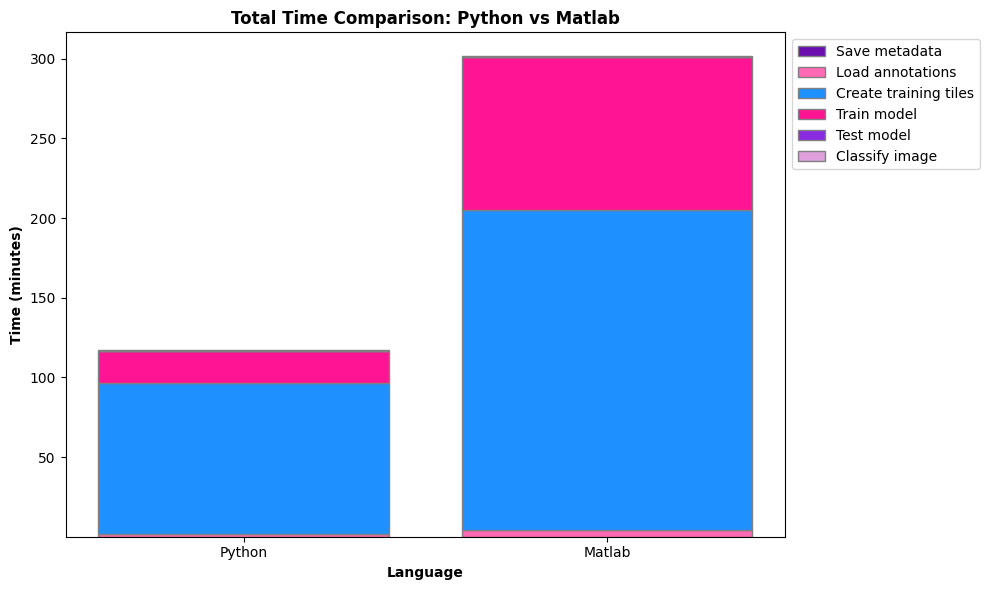

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Data
tasks = ['Save metadata', 'Load annotations', 'Create training tiles', 'Train model', 'Test model', 'Classify image']
python_times = [0.001, 1.5, 95, 20, 0.15, 0.28]
matlab_times = [0.00833, 4, 201, 96, 0.15, 0.28]

# Data for plotting
labels = ['Python', 'Matlab']
times = [python_times, matlab_times]

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define the bottom for each bar
bottom_python = 0
bottom_matlab = 0

# Colors for each task in RGB format
colors = [(106/255, 13/255, 173/255), (255/255, 105/255, 180/255), (30/255, 144/255, 255/255),
          (255/255, 20/255, 147/255), (138/255, 43/255, 226/255), (221/255, 160/255, 221/255)]

# Plot each task as a segment of the bar
for i in range(len(tasks)):
    ax.bar(labels[0], python_times[i], bottom=bottom_python, color=colors[i], edgecolor='grey', label=tasks[i])
    ax.bar(labels[1], matlab_times[i], bottom=bottom_matlab, color=colors[i], edgecolor='grey')
    bottom_python += python_times[i]
    bottom_matlab += matlab_times[i]

# Add labels
ax.set_xlabel('Language', fontweight='bold')
ax.set_ylabel('Time (minutes)', fontweight='bold')
ax.set_title('Total Time Comparison: Python vs Matlab', fontweight='bold')

# Create a custom legend
handles = [plt.Rectangle((0,0),1,1, facecolor=colors[i], edgecolor='grey') for i in range(len(tasks))]
ax.legend(handles, tasks, loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.show()